# Programming with RDDs

#### Links

* https://spark.apache.org/docs/1.6.0/programming-guide.html#resilient-distributed-datasets-rdds
* https://spark.apache.org/docs/1.1.1/api/python/pyspark.rdd.RDD-class.html

In [1]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'

import os
import sys
import glob
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append('./')

from utils import *


os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.5"

In [2]:
!spark-submit --version

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /___/ .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/
                        
Type --help for more information.


## Запускаем Spark

In [3]:
import pyspark
from pyspark.conf import SparkConf
from pyspark.sql import SQLContext


conf = SparkConf()
conf.setMaster("yarn-client")
conf.set("spark.executor.instances", "2")
conf.set("spark.executor.cores", "4")

conf.set("spark.executor.memory", "6g")
conf.set("spark.core.connection.ack.wait.timeout", "1200")

# conf.set("spark.dynamicAllocation.enabled", "true")
# conf.set("spark.shuffle.service.enabled", "true")
# conf.set("spark.dynamicAllocation.initialExecutors", 2)
# conf.set("spark.dynamicAllocation.maxExecutors", 2)

sc = pyspark.SparkContext(conf = conf)
sc.addPyFile('./utils.py')
sqlContext = SQLContext(sc)

## Работа с hdfs

Утилитой командной строки -- `hdfs` (https://hadoop.apache.org/docs/current/hadoop-project-dist/hadoop-common/FileSystemShell.html)

Полезные команды:
* `hdfs dfs -ls [<path>]`
* `hdfs dfs -rm <path>`
* `hdfs dfs -mv <src> <dst>`
* `hdfs dfs -copyToLocal <src> <dst local>`
* `hdfs dfs -copyFromLocal <src local> <dst>`


### Копирование данных

Прежде чем начать работать с самим данными их нужно сохранить в hdfs.

1. Запустите terminal через Jupyter
2. `hdfs dfs -copyFromLocal data .`


Проверяем, что все данные на месте

In [4]:
! hdfs dfs -ls data/ml-25m/

Found 9 items
-rw-r--r--   1 root supergroup      10460 2020-02-05 00:44 data/ml-25m/README.txt
-rw-r--r--   1 root supergroup  435164157 2020-02-05 00:44 data/ml-25m/genome-scores.csv
-rw-r--r--   1 root supergroup      18103 2020-02-05 00:44 data/ml-25m/genome-tags.csv
-rw-r--r--   1 root supergroup    1368578 2020-02-05 00:44 data/ml-25m/links.csv
-rw-r--r--   1 root supergroup      12022 2020-02-05 00:44 data/ml-25m/ml-25m-README.htm
-rw-r--r--   1 root supergroup    3038099 2020-02-05 00:44 data/ml-25m/movies.csv
-rw-r--r--   1 root supergroup  678260987 2020-02-05 00:44 data/ml-25m/ratings.csv
-rw-r--r--   1 root supergroup   38810332 2020-02-05 00:44 data/ml-25m/tags.csv
-rw-r--r--   1 root supergroup  404281742 2020-02-05 00:44 data/ml-25m/tmdb.json


### Чтение данных

*Замечание*: Файл `ml-25m-README.htm` содержит описание данных

In [5]:
DATA_PATH = 'data/ml-25m'

RATINGS_PATH = os.path.join(DATA_PATH, 'ratings.csv')
MOVIES_PATH = os.path.join(DATA_PATH, 'movies.csv')
TAGS_PATH = os.path.join(DATA_PATH, 'tags.csv')

In [6]:
ratings = sc.textFile(RATINGS_PATH)

In [7]:
ratings.take(5)

['userId,movieId,rating,timestamp',
 '1,296,5.0,1147880044',
 '1,306,3.5,1147868817',
 '1,307,5.0,1147868828',
 '1,665,5.0,1147878820']

In [8]:
ratings.getNumPartitions()

5

In [9]:
ratings = ratings \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .map(lambda arr: Rating(user_id=int(arr[0]), 
                            movie_id=int(arr[1]), 
                            rating=float(arr[2]), 
                            timestamp=int(arr[3])))

In [10]:
ratings.count()

25000095

Количество пользователей

In [11]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 17.3 ms, sys: 3.46 ms, total: 20.8 ms
Wall time: 54.9 s


162541

Сохраним датасет в память

In [12]:
ratings = ratings.persist()

In [13]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 13.6 ms, sys: 6.2 ms, total: 19.8 ms
Wall time: 1min 24s


162541

In [14]:
ratings = ratings.coalesce(4)

In [15]:
%%time

ratings \
    .map(lambda r: r.user_id)\
    .distinct()\
    .count()

CPU times: user 12.1 ms, sys: 1.71 ms, total: 13.8 ms
Wall time: 22.5 s


162541

Количество фильмов

In [16]:
ratings \
    .map(lambda r: r.movie_id)\
    .distinct()\
    .count()

59047

## Упражнения

### Фильмы с наибольшим средним рейтингом

Найти 10 фильмов с наибольшим средним рейтингом. Вывести их названия и средний рейтинг

In [17]:
movies = sc.textFile(MOVIES_PATH)
movies.take(5)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy',
 '2,Jumanji (1995),Adventure|Children|Fantasy',
 '3,Grumpier Old Men (1995),Comedy|Romance',
 '4,Waiting to Exhale (1995),Comedy|Drama|Romance']

In [18]:
%%time
movies = movies \
    .map(lambda s: s.split(',')[:2]) \
    .filter(lambda arr: arr[0].isdigit()) \
    .keyBy(lambda arr: int(arr[0]))

movie_avg_rating = ratings \
    .map(lambda r: (r.movie_id, (r.rating, 1))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda ratings: ratings[0] / ratings[1])

movie_avg_rating \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False)\
    .take(10)

CPU times: user 44.7 ms, sys: 8.31 ms, total: 53 ms
Wall time: 29.8 s


[(105846, (5.0, ['105846', 'Only Daughter (2013)'])),
 (148164, (5.0, ['148164', 'The Coca-Cola Case (2009)'])),
 (131922, (5.0, ['131922', 'Private Duty Nurses (1971)'])),
 (148308, (5.0, ['148308', 'Cold Turkey (2013)'])),
 (130206, (5.0, ['130206', 'Picture Mommy Dead (1966)'])),
 (149268, (5.0, ['149268', 'The Pied Piper (1942)'])),
 (169746, (5.0, ['169746', 'Humans vs Zombies (2011)'])),
 (150612, (5.0, ['150612', 'Rumors of Wars (2014)'])),
 (133626, (5.0, ['133626', 'The Good Lie (2013)'])),
 (169740, (5.0, ['169740', 'Zombie Hamlet (2012)']))]

Сохраните `rdd`, состоящий из строк вида `<movie_id>,<average_rating>` на hdfs в виде текстового файла

In [19]:
movie_avg_rating\
    .repartition(10) \
    .saveAsTextFile(os.path.join(DATA_PATH, 'movie_avg_rating'))

In [20]:
! hdfs dfs -ls data/ml-25m/movie_avg_rating

Found 11 items
-rw-r--r--   1 root supergroup          0 2020-02-05 00:49 data/ml-25m/movie_avg_rating/_SUCCESS
-rw-r--r--   1 root supergroup     145865 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00000
-rw-r--r--   1 root supergroup     118120 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00001
-rw-r--r--   1 root supergroup     131498 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00002
-rw-r--r--   1 root supergroup     102561 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00003
-rw-r--r--   1 root supergroup     100893 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00004
-rw-r--r--   1 root supergroup      41597 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00005
-rw-r--r--   1 root supergroup      69084 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00006
-rw-r--r--   1 root supergroup     134632 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-00007
-rw-r--r--   1 root supergroup     177582 2020-02-05 00:49 data/ml-25m/movie_avg_rating/part-000

### Популярность тэгов

Найти 20 наиболее популярных тэгов

In [21]:
tags = sc.textFile(TAGS_PATH)
tags.take(5)

['userId,movieId,tag,timestamp',
 '3,260,classic,1439472355',
 '3,260,sci-fi,1439472256',
 '4,1732,dark comedy,1573943598',
 '4,1732,great dialogue,1573943604']

In [22]:
tags_count = tags\
    .map(lambda s: (s.split(',')[2], 1))\
    .reduceByKey(lambda a, b: a + b)\
    .collect()

len(tags_count)

73016

In [23]:
tags_count = sorted(tags_count, key=lambda tag_count: tag_count[1], reverse=True)

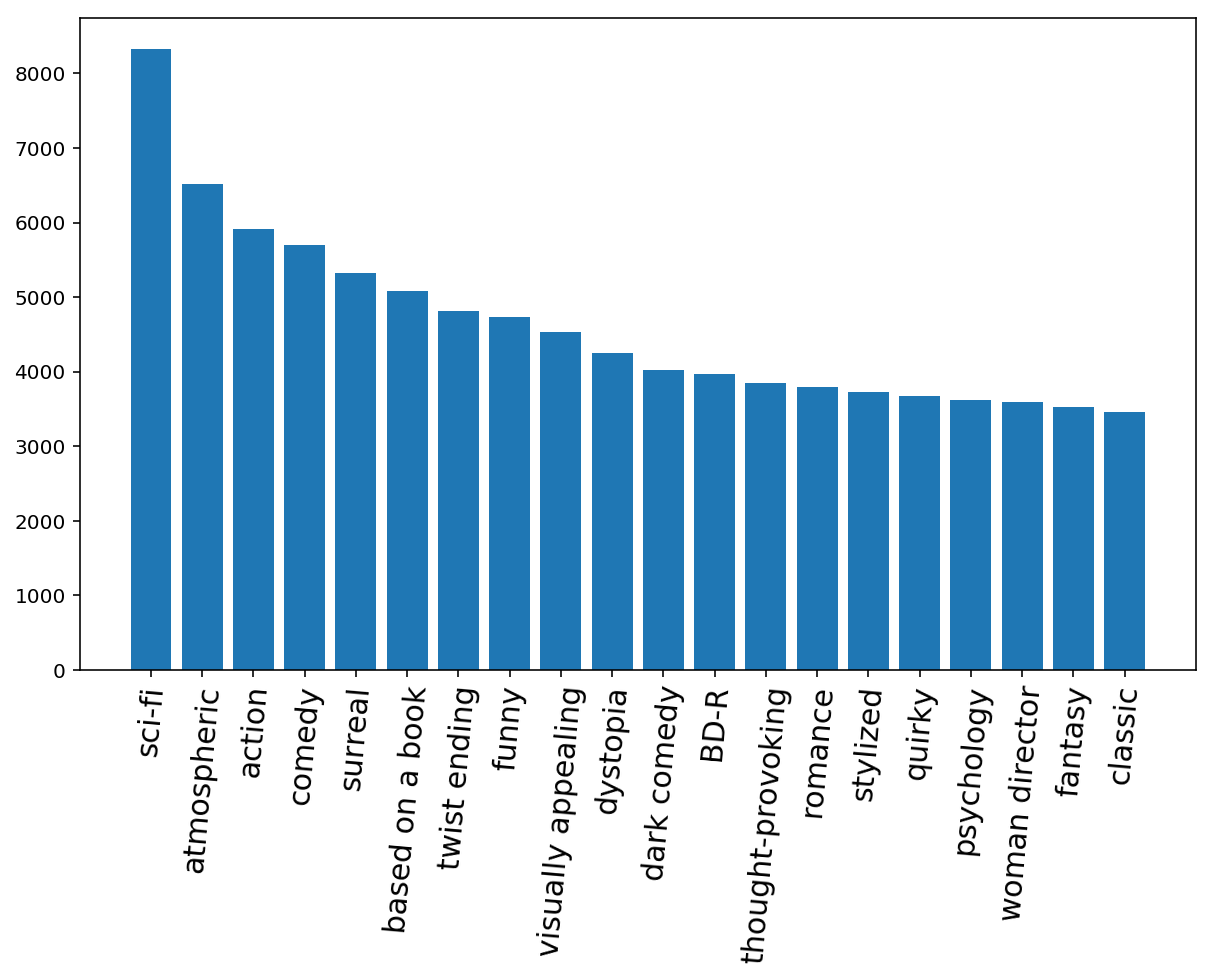

In [24]:
keys, values = zip(*tags_count[:20])

f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation=85, fontsize=15)
plt.bar(keys, values, align="center")
plt.show()

### Фильмы с наибольшим числом оценок

Найти 10 фильмов с наибольшим числом оценок. Вывести их названия и число оценок

In [25]:
movie_rating_count = ratings \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: (a + b)) \

movie_rating_count \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)

[(356, (81491, ['356', 'Forrest Gump (1994)'])),
 (318, (81482, ['318', '"Shawshank Redemption'])),
 (296, (79672, ['296', 'Pulp Fiction (1994)'])),
 (593, (74127, ['593', '"Silence of the Lambs'])),
 (2571, (72674, ['2571', '"Matrix'])),
 (260, (68717, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (480, (64144, ['480', 'Jurassic Park (1993)'])),
 (527, (60411, ['527', "Schindler's List (1993)"])),
 (110, (59184, ['110', 'Braveheart (1995)'])),
 (2959, (58773, ['2959', 'Fight Club (1999)']))]

### Фильмы с наибольшим числом 5

Найти 10 фильмов с наибольшим числом 5ок в качестве оценки. Вывести их названия и число 5ок

In [26]:
movies_5_count = ratings \
    .filter(lambda r: r.rating == 5) \
    .map(lambda r: (r.movie_id, 1)) \
    .reduceByKey(lambda a, b: (a + b))
    
movies_5_count \
    .join(movies) \
    .sortBy(lambda key_value: key_value[1][0], ascending=False) \
    .take(10)

[(318, (39553, ['318', '"Shawshank Redemption'])),
 (296, (32169, ['296', 'Pulp Fiction (1994)'])),
 (356, (25918, ['356', 'Forrest Gump (1994)'])),
 (260, (25804, ['260', 'Star Wars: Episode IV - A New Hope (1977)'])),
 (2571, (25482, ['2571', '"Matrix'])),
 (527, (24853, ['527', "Schindler's List (1993)"])),
 (593, (24801, ['593', '"Silence of the Lambs'])),
 (858, (24418, ['858', '"Godfather'])),
 (50, (21585, ['50', '"Usual Suspects'])),
 (2959, (21486, ['2959', 'Fight Club (1999)']))]

### Распределение рейтингов фильмов

Построить распределение фильмов по ср. рейтингам  (гистограмму)

In [27]:
import seaborn as sns
sns.set()

In [28]:
avg_ratings = movie_avg_rating.values().collect()

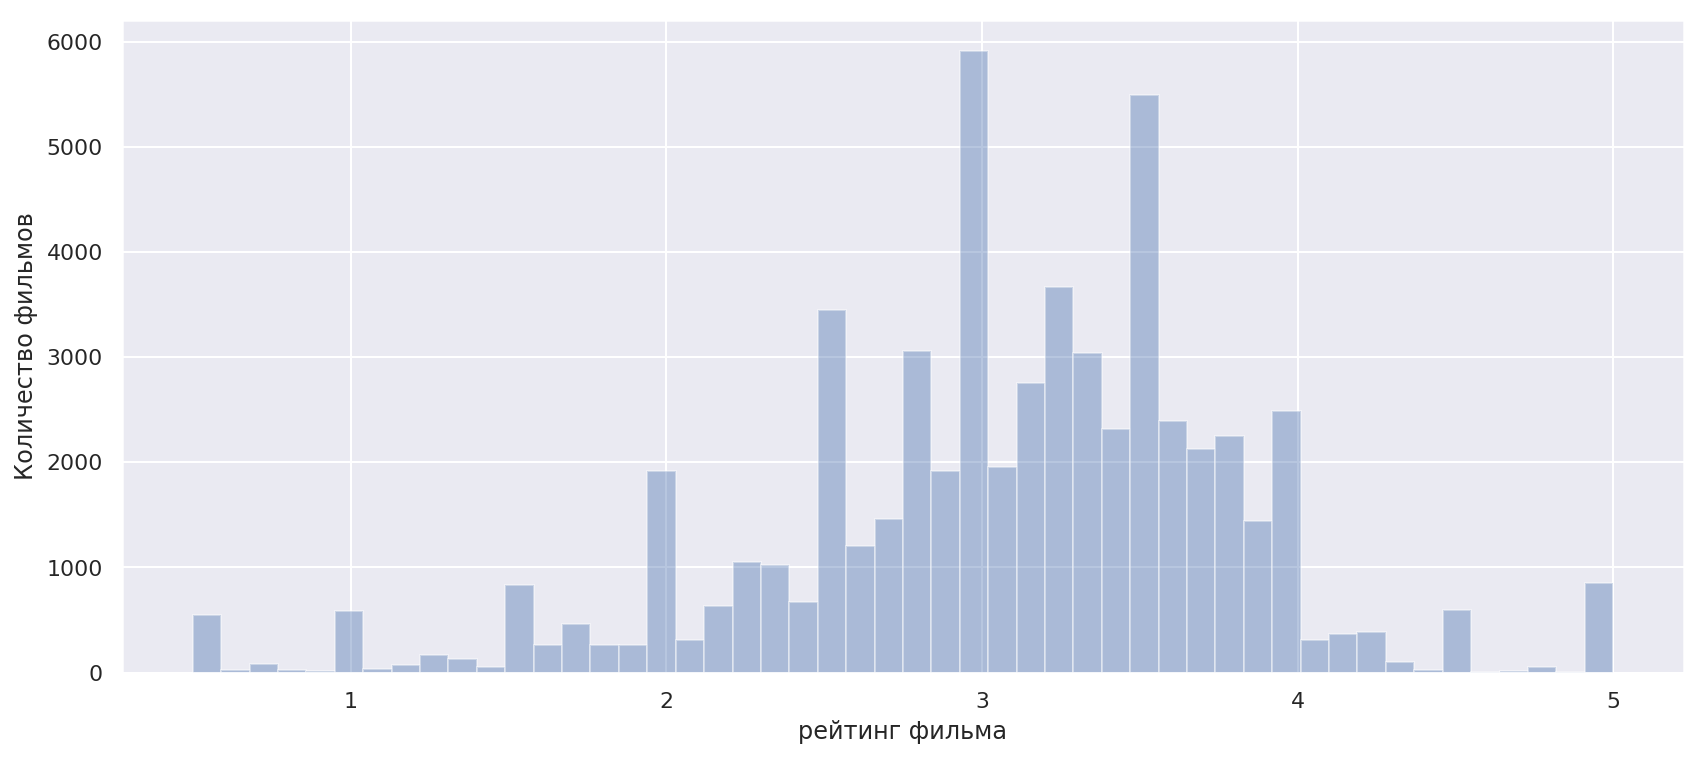

In [29]:
plt.figure(figsize=(14, 6))
ax = sns.distplot(avg_ratings, kde=False, axlabel="рейтинг фильма")
ax.set_ylabel('Количество фильмов')
plt.show()

### Распределение числа оценок для фильмов

Построить распределение фильмов по числу оценок

In [30]:
rating_count = movie_rating_count.values().collect()

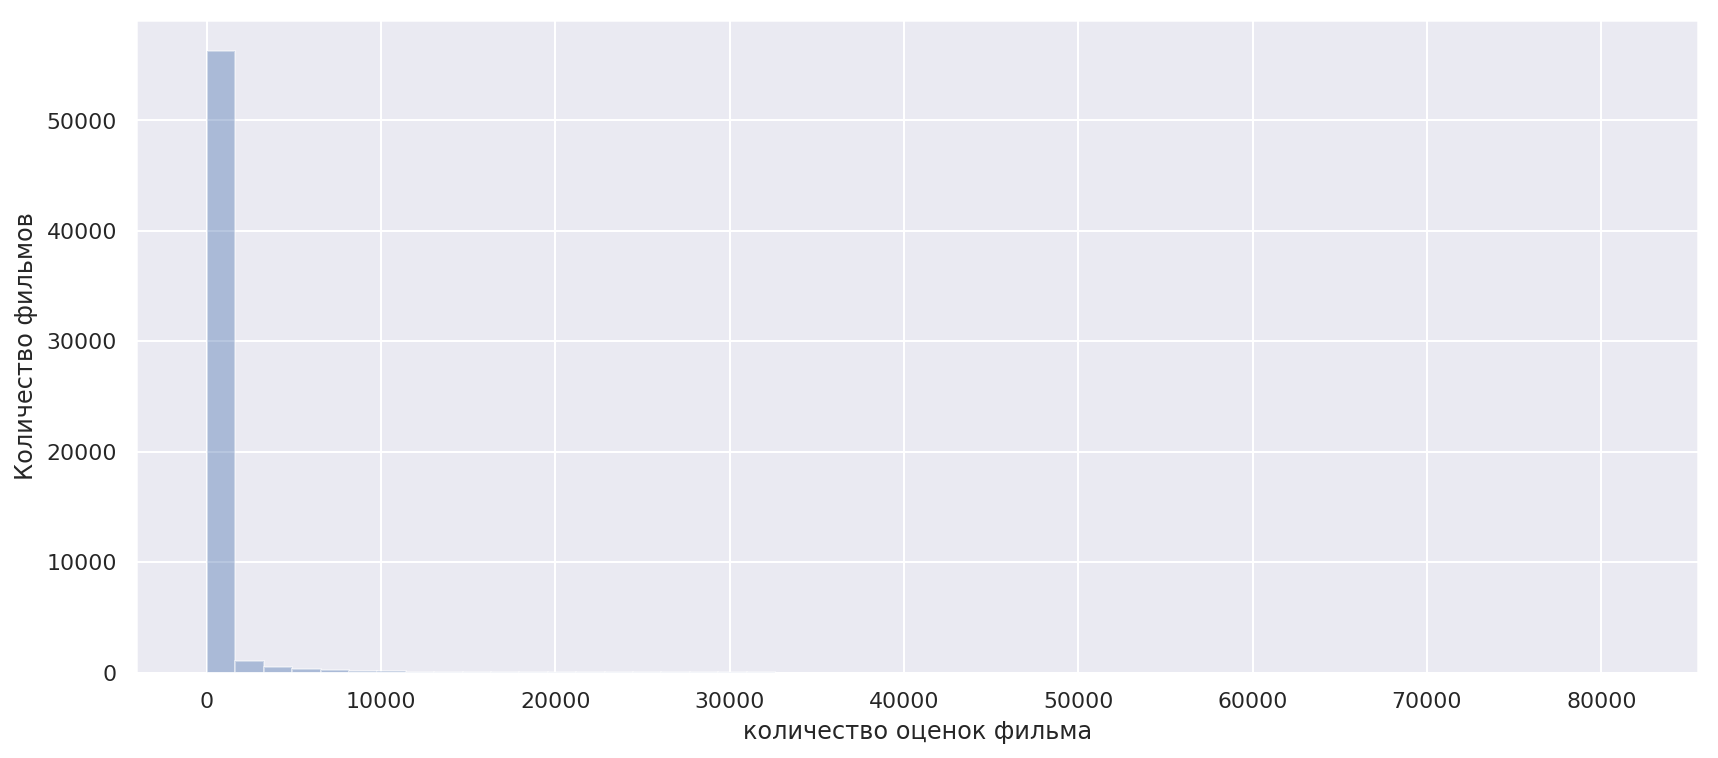

In [31]:
plt.figure(figsize=(14, 6))
ax = sns.distplot(rating_count, kde=False, axlabel="количество оценок фильма")
ax.set_ylabel('Количество фильмов')
plt.show()

### Распределение фильмов по жанрам

Построить гистограмму распределения фильмов по жанрам. Обратите внимание, что у фильма может быть указано больше одного жанра.

In [32]:
sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit()) \
    .take(3)

[['1', 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'],
 ['2', 'Jumanji (1995)', 'Adventure|Children|Fantasy'],
 ['3', 'Grumpier Old Men (1995)', 'Comedy|Romance']]

In [33]:
genres = sc.textFile(MOVIES_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda arr: arr[0].isdigit())    

In [34]:
genres_count = genres \
    .map(lambda s: s[2]) \
    .flatMap(lambda s: s.split('|')) \
    .countByValue()

In [35]:
from collections import Counter

In [36]:
genres_counter = Counter(genres_count)

In [37]:
genres_counter.most_common(5)

[('Drama', 22111),
 ('Comedy', 14831),
 ('Thriller', 7645),
 ('Romance', 6718),
 ('Action', 6678)]

In [38]:
most_popular_genre, values = zip(*genres_counter.most_common(20))

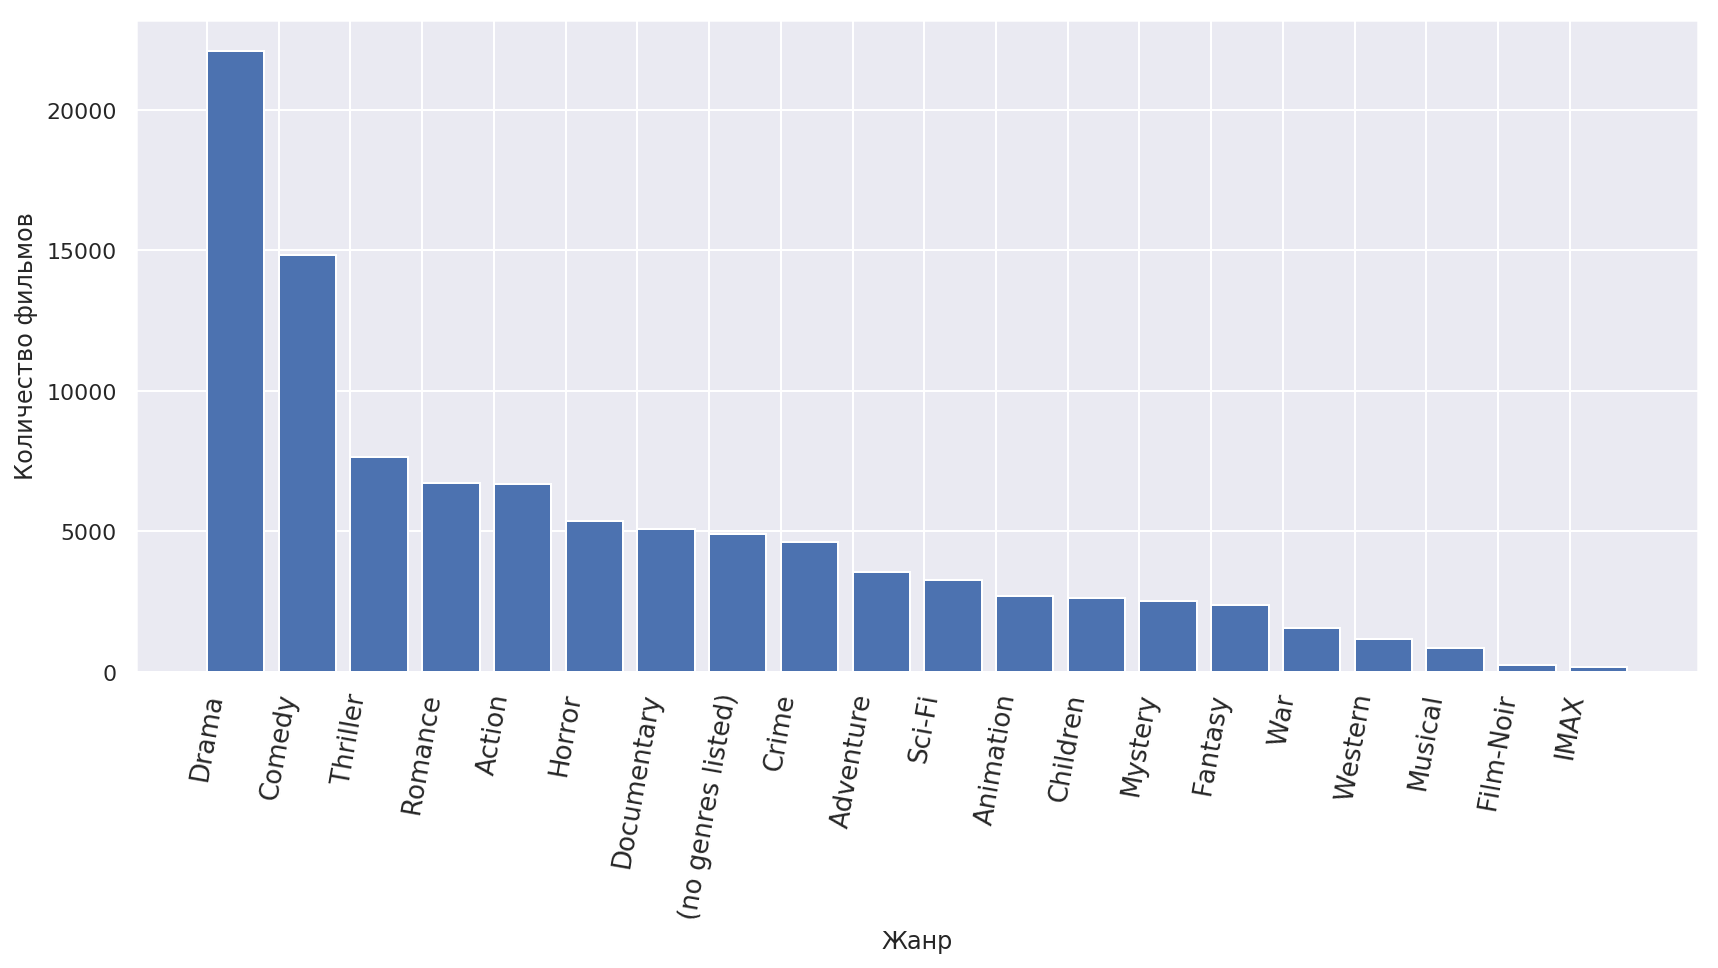

In [39]:
plt.figure(figsize=(14, 6))
plt.bar(most_popular_genre, values, align="edge")
plt.ylabel('Количество фильмов')
plt.xlabel("Жанр")
plt.xticks(rotation=80, fontsize=13)
plt.show()

### Актеры

Для решения задач ниже нужно воспользоваться файлами `ratings.csv`, `movies.csv`, `links.csv` и `tmdb.json`.

* `links.csv` - задает отображение из `movie_id` в `tmdb_movie_id` (подробное описание в `ml-25m-README.htm`)
* `tmdb.json` - содержит большое количество данных о фильмах в формате json (на каждой строчке отдельный json)

Задачи

1. Найти все фильмы, в которых играл `"id":31, "name":"Tom Hanks"`
2. Найти 10 актеров снявшихся в наибольшем числе фильмов. Вывести их имена и кол-во фильмов, в которых они снимались

In [40]:
LINKS_PATH = os.path.join(DATA_PATH, 'links.csv')
TMDB_PATH = os.path.join(DATA_PATH, 'tmdb.json')

In [41]:
sc.textFile(LINKS_PATH).take(5)

['movieId,imdbId,tmdbId',
 '1,0114709,862',
 '2,0113497,8844',
 '3,0113228,15602',
 '4,0114885,31357']

In [42]:
links = sc.textFile(LINKS_PATH) \
    .map(lambda s: s.split(',')) \
    .filter(lambda s: s[0].isdigit() and s[2].isdigit()) \
    .map(lambda s: (int(s[0]), int(s[2]))) \
    .keyBy(lambda arr: int(arr[0]))

links.take(5)

[(1, (1, 862)),
 (2, (2, 8844)),
 (3, (3, 15602)),
 (4, (4, 31357)),
 (5, (5, 11862))]

In [43]:
import json

In [44]:
sc.textFile(TMDB_PATH)

data/ml-25m/tmdb.json MapPartitionsRDD[114] at textFile at NativeMethodAccessorImpl.java:-2

In [45]:
tmdb = sc.textFile(TMDB_PATH) \
    .map(lambda s: json.loads(s))\
    .filter(lambda movie: 'casts' in movie)\
    .keyBy(lambda movie: int(movie['id']))

In [46]:
full_cast = tmdb \
    .flatMapValues(lambda movie: movie['casts']['cast'])

#### Задача 1

In [47]:
TOM_HANKS_ID = 31

In [48]:
movies = full_cast \
    .filter(lambda key_value: key_value[1]['id'] == TOM_HANKS_ID) \
    .keyBy(lambda key_value: key_value[0]) \
    .join(tmdb) \
    .map(lambda x: x[1][1]['title']) \
    .collect()

In [49]:
print(*movies[:10], sep='\n')

The Terminal
Sleepless in Seattle
Big
California Typewriter
Beyond Boundaries: The Harvey Weinstein Scandal
Cast Away
He Knows You're Alone
Mazes and Monsters
The Celluloid Closet
Forrest Gump


#### Задача 2

In [50]:
full_cast \
    .mapValues(lambda x: (x['id'], x['name'])) \
    .keyBy(lambda key_value: key_value[1][0]) \
    .mapValues(lambda x: (x[1][1], 1)) \
    .reduceByKey(lambda a, b: (a[0], a[1] + b[1])) \
    .sortBy(lambda key_value: key_value[1][1], ascending=False) \
    .take(10)

[(121323, ('Bess Flowers', 380)),
 (15831, ('Frank Welker', 184)),
 (113, ('Christopher Lee', 175)),
 (78077, ('Clarence Nash', 158)),
 (30530, ('Irving Bacon', 152)),
 (8516, ('John Carradine', 146)),
 (4165, ('John Wayne', 142)),
 (33923, ('Mel Blanc', 140)),
 (2231, ('Samuel L. Jackson', 134)),
 (21315, ('Eric Roberts', 130))]

### Доля жанра в течении времени

Для каждого жанра нужно построить как менялась доля вышедших фильмов данного жанра относительно всех остальных жанров.

Дату выхода фильма можно взять из файла `tmdb.json`.

(См. `plt.stackplot`)

In [51]:
import numpy as np

In [52]:
tmdbid_to_year = tmdb \
    .mapValues(lambda movie: movie['release_date']) \
    .filter(lambda x: x[1][:4].isdigit()) \
    .mapValues(lambda x: int(x[:4])) \
    .keyBy(lambda x: int(x[0])) \
    .mapValues(lambda x: x[1]) \

tmdbid_to_year.take(2)

[(862, 1995), (8844, 1995)]

In [53]:
start_year, end_year = tmdbid_to_year.values().min(), tmdbid_to_year.values().max()

In [54]:
movie_id_genres = genres \
    .flatMap(lambda s: [(int(s[0]), genre) for genre in s[2].split('|')])

movie_id_genres.take(2)

[(1, 'Adventure'), (1, 'Animation')]

In [55]:
n_years = end_year - start_year + 1
one_hots = np.eye((n_years))
genre_per_year = links \
    .join(movie_id_genres) \
    .map(lambda x: (x[1][0][1], x[1][1])) \
    .join(tmdbid_to_year) \
    .values() \
    .mapValues(lambda year: one_hots[year - start_year]) \
    .filter(lambda x: x[0] in most_popular_genre) \
    .reduceByKey(np.add)

In [56]:
total_films_per_year = genre_per_year.values().sum()

In [57]:
genre_per_year_percent = genre_per_year \
    .mapValues(lambda x: x / total_films_per_year)\
    .mapValues(lambda x: np.nan_to_num(x)) \
    .collect()

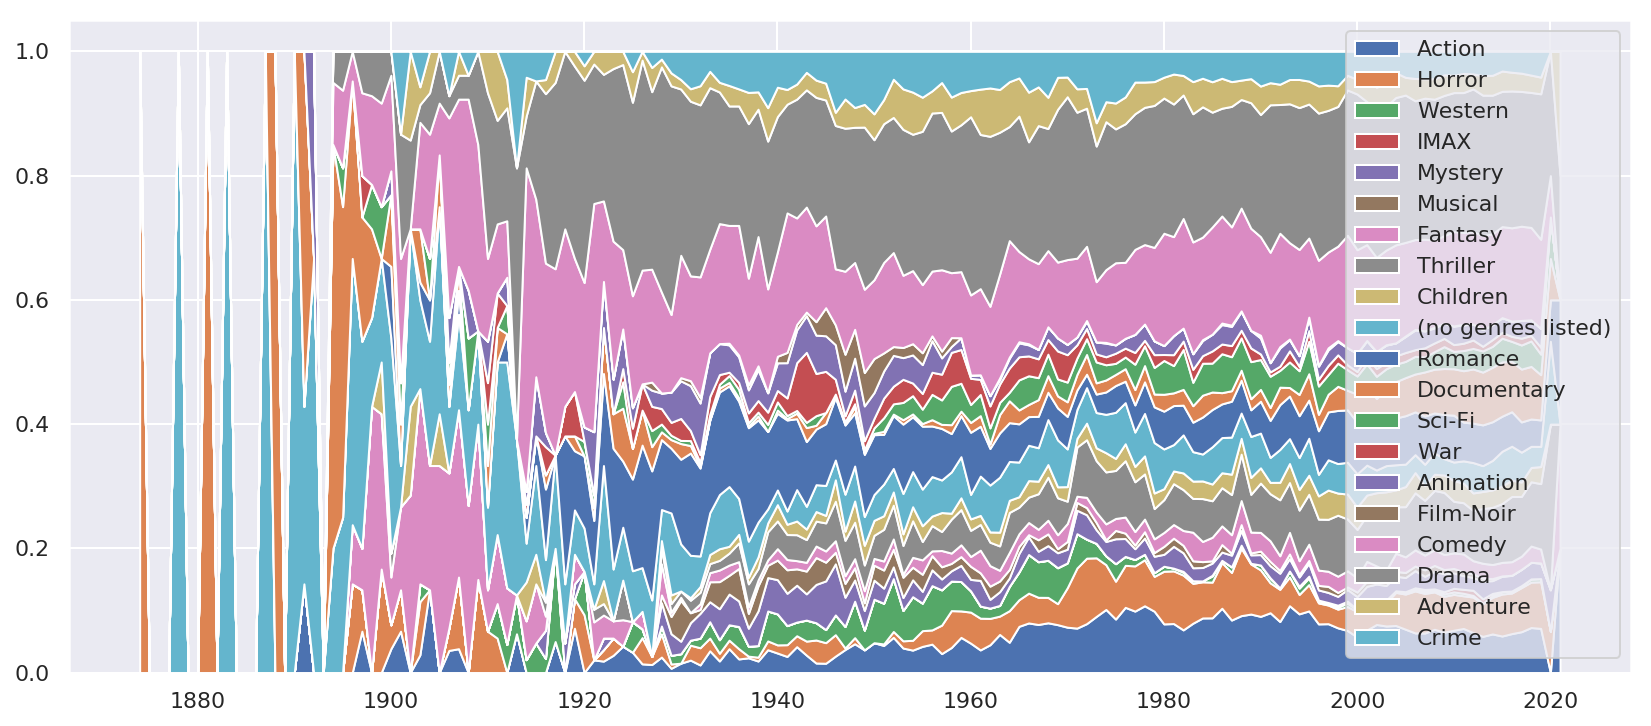

In [58]:
genres_names, percent = zip(*genre_per_year_percent)

plt.figure(figsize=(14, 6))
plt.stackplot(np.arange(start_year, end_year + 1), percent, labels=genres_names)
plt.legend()
plt.show()

### Окупаемость фильмов

Для каждого жанра посчитать `ROI = mean(revenue) / mean(budget)` и построить `barplot`, где по оси x будет название жанра, а по оси y - `ROI`

Данные о `revenue` и `budget` можно найти в файле `tmdb.json`.

In [59]:
movie_money = tmdb \
    .mapValues(lambda movie: (movie["revenue"], movie["budget"]))

movie_money.take(3)

[(862, (373554033, 30000000)), (8844, (262797249, 65000000)), (15602, (0, 0))]

In [60]:
genre_roi = links \
    .join(movie_id_genres) \
    .map(lambda x: (x[1][0][1], x[1][1])) \
    .join(movie_money) \
    .values() \
    .filter(lambda x: x[0] in most_popular_genre) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1] + b[1])) \
    .mapValues(lambda x: x[0] / x[1]) \
    .collect()

In [61]:
genre_roi = sorted(genre_roi, key=lambda x: x[1], reverse=True)
genre_roi[:3]

[('Animation', 3.605589236338009),
 ('IMAX', 3.500536723269289),
 ('Adventure', 3.2353774983513284)]

In [62]:
genres_name, genres_roi = zip(*genre_roi)

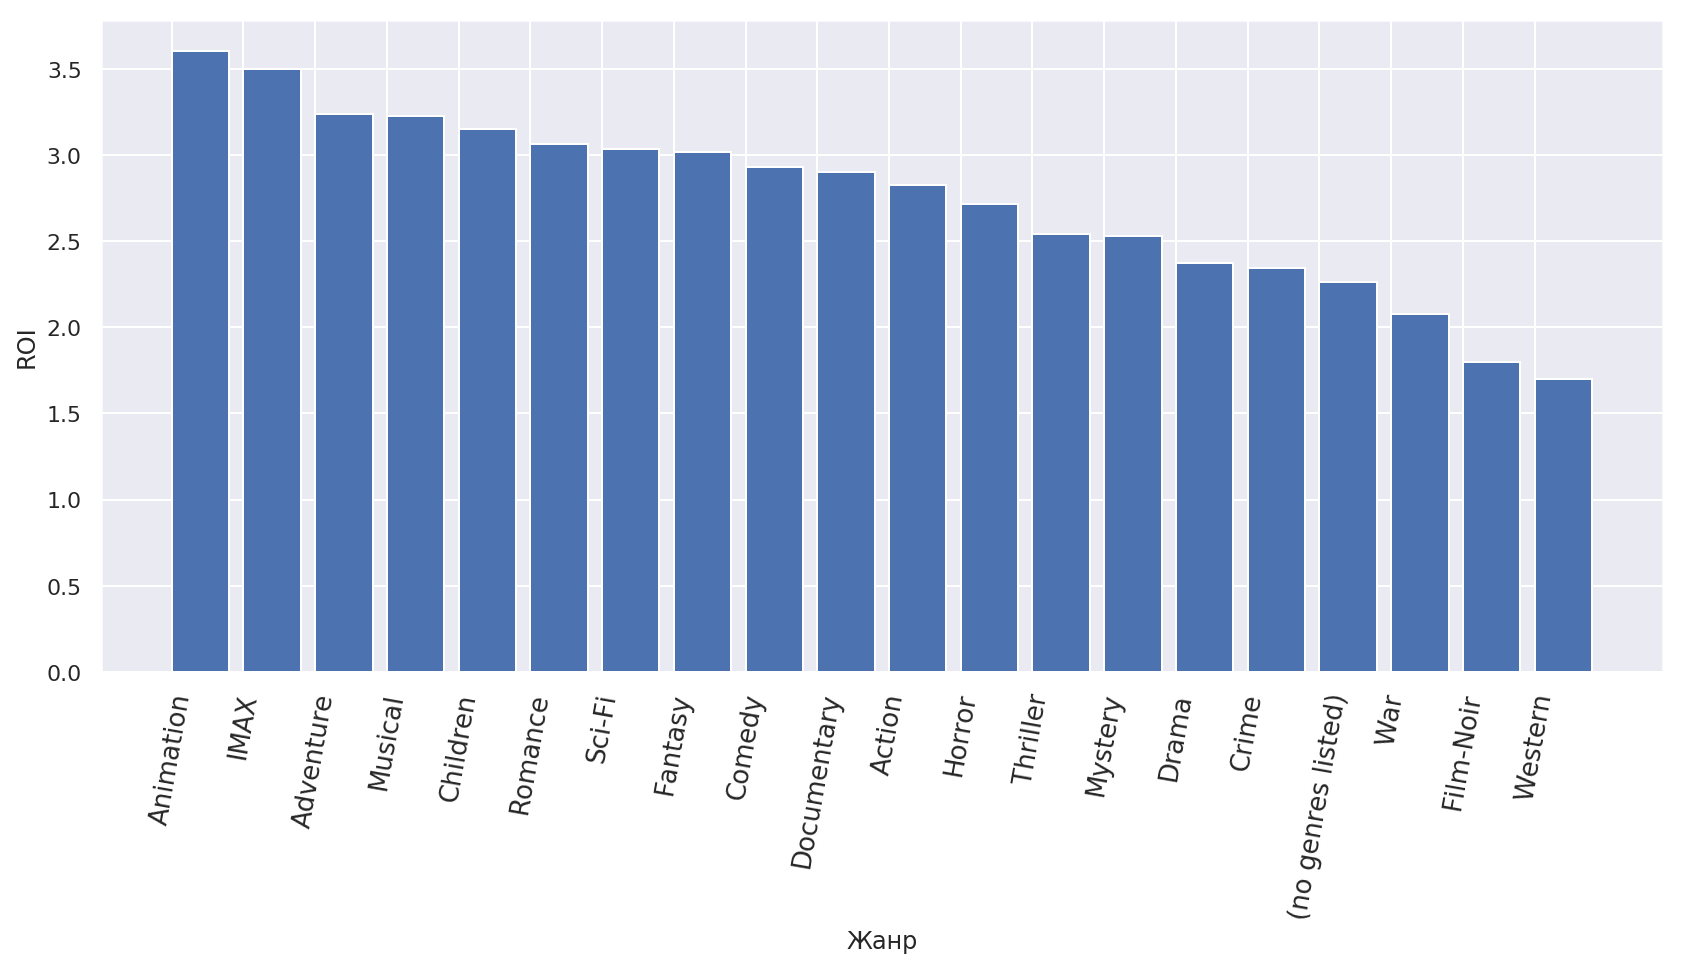

In [63]:
plt.figure(figsize=(14, 6))
plt.bar(genres_name, genres_roi, align="edge")
plt.ylabel('ROI')
plt.xlabel("Жанр")
plt.xticks(rotation=80, fontsize=13)
plt.show()